In [40]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import h5py
import os
import time
import pickle
import seaborn as sns
from anndata import read_h5ad

import sceb.data_loader as dl
import sceb.scdd as sd
import scanpy.api as sc

%matplotlib inline
%load_ext autoreload
%autoreload 2

# from matplotlib import rcParams

# params = {
#    'axes.labelsize': 16,
#    'font.size': 16,
#    'legend.fontsize': 10,
#    'xtick.labelsize': 13,
#    'ytick.labelsize': 13,
#    'text.usetex': False,
#    'text.usetex': False,
#    }
# rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
output_folder = '/home/martin/single_cell_eb/figures/figure_sensitivity'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

## Load data

In [42]:
## Collect the data
dataset={}
## Collect the data
dataset={}
dataset['brain_1k'] = dl.load_10x_1k() # 1k brain cells 
dataset['brain_2k'] = dl.load_10x_2k() # 2k brain cells 
dataset['brain_9k'] = dl.load_10x_9k() # 9k brain cells 
# dataset['brain_1.3m'] = dl.load_10x_1_3mil() # 1.3 million brain cells 
dataset['pbmc_4k'] = dl.load_10x_4k() # 4k PBMC cells
dataset['pbmc_8k'] = dl.load_10x_8k() # 8k PBMC cells 

/home/martin/anaconda3/lib/python3.6/site-packages/anndata/readwrite/read.py:451: DeprecationWarning: In a future version, read_h5ad will no longer explicitly support boolean arguments. Specify the read mode, or leave `backed=None`.
  DeprecationWarning,
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/martin/single_cell_eb/sceb/data_loader.py:228: DeprecationWarning: Use obs_names instead of smp_names, smp_names will be removed in the future.
  data.smp_names = np.genfromtxt(filename_barcodes, dtype=str)
/home/martin/anaconda3/lib/python3.6/site-packages/anndata/readwrite/read.py:451: DeprecationWarning: In a future version, read_h5ad will no longer explicitly support boolean arguments. Specify the read mode, or leave `backed=None`.
  DeprecationWarning,
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/martin/single_cell_eb/sceb/data_loader.py:200: DeprecationWarning: Use obs_names instead of smp_names, sm

In [4]:
# dataset['bulk_Zucca_2019'] =  read_h5ad('/data/martin/single_cell/PBMC_Zucca_2019/bulk_Zucca_2019.h5ad')

In [44]:
# data from Jiarui Ding et al, biorxiv, 2019
temp_file = '/data/martin/single_cell/Ding_Levin_biorxiv_2019'
dataset['bulk_pbmc1'] =  read_h5ad(temp_file + '/rsem.bulk.pbmc1.h5ad')
dataset['bulk_pbmc2'] =  read_h5ad(temp_file + '/rsem.bulk.pbmc2.h5ad')
dataset['10x2A_pbmc1'] =  read_h5ad(temp_file + '/pbmc1.10xChromiumv2A.h5ad')
dataset['10x2B_pbmc1'] =  read_h5ad(temp_file + '/pbmc1.10xChromiumv2B.h5ad')
dataset['10x2_pbmc2'] =  read_h5ad(temp_file + '/pbmc2.10xChromiumv2.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Sensitivity analysis

In [45]:
# theoretical estimation error
def get_error_gamma(p_star,Nr,Nc):
    r = 1.5
    theta = p_star/r
    c_gamma_1 = 1
    c_gamma_2 = 1
    # error_theta
    error_theta = (2*r+3)*theta**2/r \
                 + (4*r+5)*theta/Nr/r*c_gamma_1 \
                 + 2*(r+1)/Nr**2/r*c_gamma_2
    error_theta /= Nc
    error_theta /= theta**2
    # error_r
    error_r = 2*r*(r+1) \
              + 4*r*(r+1)/theta/Nr*c_gamma_1 \
              + 2*r*(r+1)/Nr**2/theta**2*c_gamma_2
    error_r /= Nc
    error_r /= r**2
    return (error_theta+error_r)/2

In [46]:
comparison_list = ['out-of-sample RNA-Seq.bulk_pbmc2.10x2A_pbmc1',
                   'in-sample RNA-Seq.bulk_pbmc1.10x2A_pbmc1',
                   'out-of-sample scRNA-seq.pbmc_4k.10x2A_pbmc1',
                   'in-sample scRNA-seq.10x2B_pbmc1.10x2A_pbmc1']
dic_rec = {}
for term in comparison_list:
    title,dname_ref,dname = term.split('.')
    # assign data set
    adata_ref = dataset[dname_ref].copy()
    adata_ref.var_names_make_unique()    
    if adata_ref.shape[0]==1:
        temp_varname = adata_ref.var_names
        temp_X = adata_ref.X
        temp_X = np.stack([temp_X, temp_X])
        adata_ref = sc.AnnData(X=temp_X)
        adata_ref.var_names = temp_varname
    if adata_ref.shape[0]>500:
        adata_ref = sd.subsample_anndata(adata_ref, 2000, 500)
        adata_ref.X = adata_ref.X.astype(float)
#         sc.pp.subsample(adata_ref, n_obs=500)
    adata = dataset[dname].copy()
    adata.var_names_make_unique()
    Nc,G,Nr,Nr_bar = sd.get_info(adata)
    B_adata = Nc * Nr
    # normalization to relative abundance
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1)
    sc.pp.normalize_per_cell(adata_ref, counts_per_cell_after=1)
    # match the gene names 
    gene_list = list(set(adata.var_names) & set(adata_ref.var_names))
    adata = adata[:, gene_list]
    adata_ref = adata_ref[:, gene_list]
    # mean exp of the genes 
    mean_adata = np.array(adata.X.mean(axis=0)).reshape([-1])
    mean_adata_ref = np.array(adata_ref.X.mean(axis=0)).reshape([-1])
    # optimal error
    Nr = 1/mean_adata
    Nc = B_adata / Nr
    opt_err = get_error_gamma(mean_adata, Nr, Nc)
    # ref error
    Nr = 1/mean_adata_ref
    Nc = B_adata / Nr
    ref_err = get_error_gamma(mean_adata, Nr, Nc)
    # record the result 
    dic_rec[title] = [dname_ref, dname, B_adata, mean_adata, mean_adata_ref,
                      opt_err, ref_err]
#     break

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Nc=5184, G=33694, Nr=2146.74, Nr_bar=0.06


/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/home/martin/anacond

## Nc=5184, G=33694, Nr=2146.74, Nr_bar=0.06


/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/home/martin/anacond

#time start: 0.0s
before cell subsamp (4340, 33694)
after cell subsamp (500, 33694)
#time sub-sample cells: 0.0603s
[[0. 0. 0. ... 5. 0. 0.]]
#time sub-sample counts: 1.5674s

## Nc=5184, G=33694, Nr=2146.74, Nr_bar=0.06


/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/home/martin/anacond

#time start: 0.0s
before cell subsamp (3222, 33694)
after cell subsamp (500, 33694)
#time sub-sample cells: 0.0493s
[[10.  0. 50. ...  0.  0.  0.]]
#time sub-sample counts: 1.0974s

## Nc=5184, G=33694, Nr=2146.74, Nr_bar=0.06


/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/home/martin/anacond

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


3690
405
0.9010989010989011


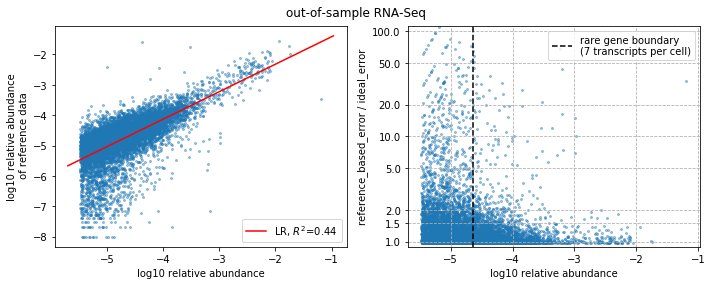

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


3759
336
0.9179487179487179


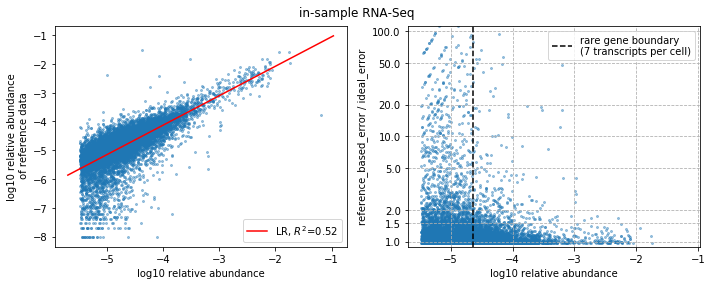

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


4149
223
0.9489935956084172


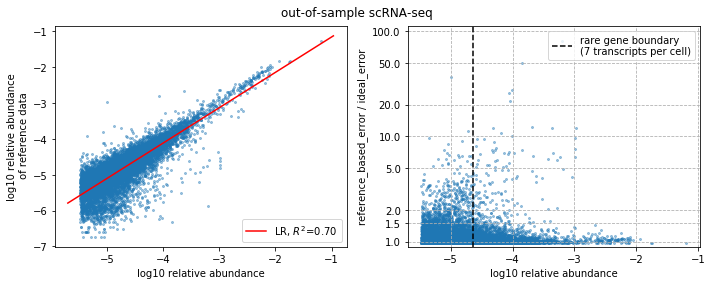

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


4340
32
0.9926806953339433


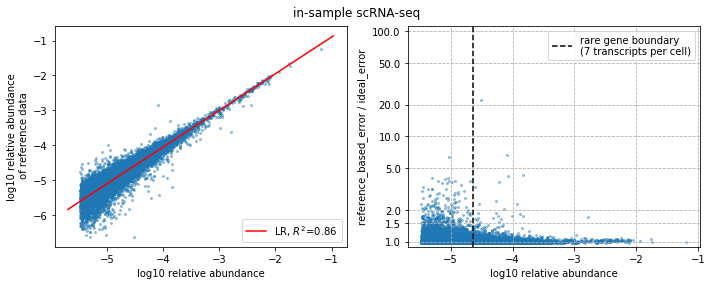

In [47]:
for title in dic_rec.keys():
    dname_ref, dname, B_adata, mean_adata, mean_adata_ref, opt_err, ref_err = dic_rec[title]
    ratio_error = ref_err/opt_err
    # Select a subset
    ind_select = (mean_adata>(1/3e5))
    mean_adata = mean_adata[ind_select]
    mean_adata_ref = mean_adata_ref[ind_select]
    ratio_error = ratio_error[ind_select]
    # Figure
    plt.figure(figsize=[10,4])
    plt.subplot(1,2,1)
    plt.scatter(np.log10(mean_adata), np.log10(mean_adata_ref), alpha=0.4, s=4)
    # Linear fit
    x_val = np.log10(mean_adata)
    y_val = np.log10(mean_adata_ref)
    ind_select = (x_val>-100) & (y_val>-100)
    x_val = x_val[ind_select]
    y_val = y_val[ind_select]
    sl,icpt,r_val,p_val,_ = sp.stats.linregress(x_val, y_val)
    x_min,x_max = plt.xlim()
    y_min,y_max = plt.ylim()
    plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
             label='LR, $R^2$=%0.2f'%(r_val**2))
    plt.legend(loc='lower right')
    plt.xlabel('log10 relative abundance')
    plt.ylabel('log10 relative abundance\n of reference data')
    plt.subplot(1,2,2)
    plt.scatter(np.log10(mean_adata), np.log10(ratio_error), alpha=0.4, s=4)
    plt.ylim([-0.05, 2.05])
    y_min,y_max = plt.ylim()
    y_ticks = np.array([1, 1.5, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
    y_ticks = y_ticks[np.log10(y_ticks)<y_max]
    plt.yticks(np.log10(y_ticks), y_ticks)
    plt.grid(linestyle='--')
    # plt.ylim([0, 10])
    x_min,x_max = plt.xlim()
    y_min,y_max = plt.ylim()
    plt.plot([np.log10(7/3e5), np.log10(7/3e5)], [y_min, y_max], 
             linestyle = '--', color='k', label='rare gene boundary \n(7 transcripts per cell)')
    plt.legend(loc='upper right')
    plt.xlabel('log10 relative abundance')
    plt.ylabel('reference_based_error / ideal_error')
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    print(np.sum((mean_adata > (7/3e5)) & (ratio_error<1.5)))
    print(np.sum((mean_adata > (7/3e5)) & (ratio_error>=1.5)))
    print(np.sum((mean_adata > (7/3e5)) & (ratio_error<1.5))/ 
          np.sum((mean_adata > (7/3e5))))
    plt.savefig(output_folder + '/%s.pdf'%title,
                transparent=True, bbox_inches='tight')
    plt.savefig(output_folder + '/%s.png'%title,
                transparent=True, bbox_inches='tight')
    plt.show()